In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import math
from datetime import datetime as dt
from IPython.display import Image, HTML

from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

In [2]:
def create_dates(start,days):
    v = pd.date_range(start=start, periods=days+1, freq='H', closed='right')
    seven_day_forecast = pd.DataFrame(index=v) 
    return seven_day_forecast

In [3]:
# get values, station name and drop null values
def get_value_name(all_station_temp,i):
    station_value = all_station_temp[[all_station_temp.columns[i]]].dropna()
    station_name = all_station_temp.columns[i]
    return station_value, station_name 

In [4]:
# train-test split for a user input ratio
def train_test_split(value, name, ratio):
    nrow = len(value)
    print(name+' total samples: ',nrow)
    split_row = int((nrow)*ratio)
    print('Training samples: ',split_row)
    print('Testing samples: ',nrow-split_row)
    train = value.iloc[:split_row]
    test = value.iloc[split_row:]
    return train, test, split_row     

In [5]:
# data transformation
def data_transformation(train_tract1,test_tract1):
    scaler = MinMaxScaler()
    train_tract1_scaled = scaler.fit_transform(train_tract1)
    test_tract1_scaled = scaler.fit_transform(test_tract1)          
    train_tract1_scaled_df = pd.DataFrame(train_tract1_scaled, index = train_tract1.index, columns=[train_tract1.columns[0]])
    test_tract1_scaled_df = pd.DataFrame(test_tract1_scaled,
                                         index = test_tract1.index, columns=[test_tract1.columns[0]])
    return train_tract1_scaled_df, test_tract1_scaled_df, scaler     

In [6]:
# feature builder - This section creates feature set with lag number of predictors--Creating features using lagged data
def timeseries_feature_builder(df, lag):
    df_copy = df.copy()
    for i in range(1,lag):
        df_copy['lag'+str(i)] = df.shift(i) 
    return df_copy
    df_copy = df.copy()

In [7]:
# preprocessing -- drop null values and make arrays 
def make_arrays(train_tract1,test_tract1):
    X_train_tract1_array = train_tract1.dropna().drop(train_tract1.columns[0], axis=1).values
    y_train_tract1_array = train_tract1.dropna()[train_tract1.columns[0]].values
    X_test_tract1_array = test_tract1.dropna().drop(test_tract1.columns[0], axis=1).values
    y_test_tract1_array = test_tract1.dropna()[test_tract1.columns[0]].values    
    return X_train_tract1_array, y_train_tract1_array, X_test_tract1_array, y_test_tract1_array

In [8]:
# validation result 
def valid_result(model, testX, y_test_tract1_array, scaler, station_value, split_row, lag):    
    testPredict = model.predict(testX)
    rSquare_test = r2_score(y_test_tract1_array, testPredict)
    print('Test R-squared is: %f'%rSquare_test)    
    testPredict = scaler.inverse_transform(testPredict)        
    new_test_tract1 = station_value.iloc[split_row:]       
    test_tract1_pred = new_test_tract1.iloc[lag:].copy()
    test_tract1_pred['Forecast'] = testPredict
   
    return test_tract1_pred

In [9]:
# multi step future forecast for next days number of days. 
def forecast(model, testX, test_tract1, lag, scaler, days):
    seven_days = []
    new0 = testX[-1]        
    last = test_tract1.iloc[-1]
    new_predict = last[0]        
    new_array = np.insert(new0, 0, new_predict)        
    new_array = np.delete(new_array, -1)
    new_array_reshape = np.reshape(new_array, (-1,1,lag))       
    new_predict = model.predict(new_array_reshape)
    temp_predict = scaler.inverse_transform(new_predict) 
    seven_days.append(temp_predict[0][0].round(2))
    
    for i in range(1,days):
        new_array = np.insert(new_array, 0, new_predict)             
        new_array = np.delete(new_array, -1)
        new_array_reshape = np.reshape(new_array, (-1,1,lag))            
        new_predict = model.predict(new_array_reshape)
        temp_predict = scaler.inverse_transform(new_predict) 
        seven_days.append(temp_predict[0][0].round(2))
    return seven_days  

In [26]:
themis=pd.read_csv(r"/Users/mertdil/Downloads/THB_L2_FGM_120345.csv",index_col=[0],parse_dates=[0])

themis

,FGS-D_B_TOTAL__nT,BX_FGS-D_(@_1_)_nT_GSM,BY_FGS-D_(@_2_)_nT_GSM,BZ_FGS-D_(@_3_)_nT_GSM
UT__yyyy-mm-ddThh:mm:ss.sssZ,,,,
2021-01-25 00:00:02.727000+00:00,10.88450,-1.765320,-6.16529,8.79458
2021-01-25 00:00:07.042000+00:00,10.79940,-1.554550,-6.30408,8.62959
2021-01-25 00:00:11.356000+00:00,10.95990,-1.946640,-5.88450,9.03896
2021-01-25 00:00:15.671000+00:00,11.21240,-3.711290,-6.41432,8.41431
2021-01-25 00:00:19.986000+00:00,11.67790,-0.810750,-6.44283,9.70597
...,...,...,...,...
2021-02-24 23:59:39.895000+00:00,7.64928,-0.123396,2.98343,-7.04240
2021-02-24 23:59:44.210000+00:00,7.38629,0.609385,2.87220,-6.77764
2021-02-24 23:59:48.524000+00:00,7.78073,0.854973,2.99411,-7.13050


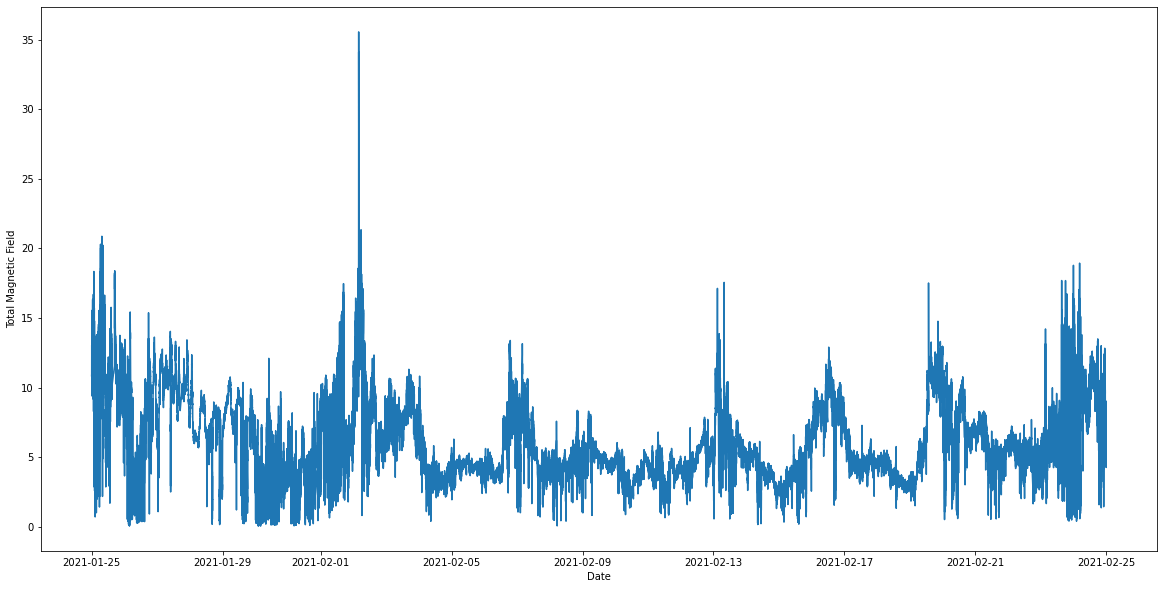

In [27]:
plt.figure(figsize=(20,10))
plt.xlabel("Date")
plt.ylabel("Total Magnetic Field")
plt.plot(themis['FGS-D_B_TOTAL__nT'])



In [13]:
# Define LSTM model
def lstm_model(units, trainX, testX, y_train_tract1_array, y_test_tract1_array):
    model = Sequential()
    model.add(LSTM(units,return_sequences=True, input_shape=(trainX.shape[1],trainX.shape[2]),kernel_initializer='lecun_uniform'))
    model.add(Dropout(0.2))    
    model.add(LSTM(units, return_sequences=True))
    model.add(Dropout(0.2))    
    model.add(LSTM(units))
    model.add(Dropout(0.2))
    model.add(Dense(1))        
    model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
    
    model.fit(trainX, y_train_tract1_array, batch_size=40, epochs=100, validation_data=(testX, y_test_tract1_array), verbose=0)
    return model

In [28]:
def england_temp_lstm(all_station_temp, lag, days):    
    
    seven_day_forecast_lstm = create_dates("2021-02-24 23:59:39.895000+00:00" ,days) 
    
    for i in range(len(all_station_temp.columns)):
        
        # preprocessing
        station_value, station_name = get_value_name(all_station_temp,i)        
        train_tract1, test_tract1, split_row = train_test_split(station_value, station_name, 0.80)        
        train_tract1_scaled_df, test_tract1_scaled_df, scaler = data_transformation(train_tract1,test_tract1) 
        train_tract1 = timeseries_feature_builder(train_tract1_scaled_df, lag+1) 
        test_tract1 = timeseries_feature_builder(test_tract1_scaled_df, lag+1)               
        X_train_tract1_array, y_train_tract1_array, X_test_tract1_array, y_test_tract1_array = make_arrays(train_tract1, 
                                                                                                           test_tract1)        
        trainX = np.reshape(X_train_tract1_array, (X_train_tract1_array.shape[0],1,X_train_tract1_array.shape[1]))
        testX = np.reshape(X_test_tract1_array, (X_test_tract1_array.shape[0],1,X_test_tract1_array.shape[1]))                
        
        # LSTM modelling & forecast
        model = lstm_model(20, trainX, testX, y_train_tract1_array, y_test_tract1_array)             
        test_tract1_pred = valid_result(model, testX, y_test_tract1_array, scaler, station_value, split_row, lag)        
        seven_days = forecast(model, testX, test_tract1, lag, scaler, days)       
        seven_day_forecast_lstm[station_name] = np.array(seven_days)       
        
        # plot result
        plt.figure(figsize=(18,10))
        plt.plot(test_tract1_pred,label="actual")
        
        plt.plot(seven_day_forecast_lstm[station_name], color='red')
        plt.xlabel("Time Interval ")
        plt.ylabel(station_name)
        plt.legend( ["actual",'predicted','forecast'])
        plt.tight_layout()
        #sns.despine(top=True)
        plt.subplots_adjust(left=0.1)
        plt.title(station_name+ " vs hours")
        plt.show()        
        print()
    return(seven_day_forecast_lstm)

In [ ]:
%%time
# Fitting and forecast using LSTM  -- output of train loss and valid loss is turned off
lstm_prediction = england_temp_lstm(themis,100,20)

FGS-D_B_TOTAL__nT total samples:  590867
Training samples:  472693
Testing samples:  118174
